# Challenge
The idea behind this challenge is for you to explore the dataset, build a prediction model from it and then code a Python module that serves the model. Therefore there will be two main parts:

1. Your Jupyter (IPython) notebook containing all your experiments, analyzes, and results. In this notebook, you will perform all your visualizations, data normalizations, training and evaluation of your model.
2. A complete Python module ready to be used containing the model you trained. This module should be coded as if the engineering team would use it so it must contain usage instructions and a clear interface (generally speaking) to access your model.

## The dataset
Kickstarter is one of the main online crowdfunding platforms in the world. The dataset provided contains more de 300,000 projects launched on the platform in 2018. In the `data.csv` file there are the following columns:

- **ID**: internal ID, _numeric_
- **name**: name of the project, _string_
- **category**: project's category, _string_
- **main_category**: campaign's category, _string_
- **currency**: project's currency, _string_
- **deadline**: project's deadline date, _timestamp_
- **goal**: fundraising goal, _numeric_
- **launched**: project's start date, _timestamp_
- **pledged**: amount pledged by backers (project's currency), _numeric_
- **state**: project's current state, _string_; **this is what you have to predict**
- **backers**: amount of poeple that backed the project, _numeric_
- **country**: project's country, _string_
- **usd pledged**: amount pledged by backers converted to USD (conversion made by KS), _numeric_
- **usd_pledged_real**: amount pledged by backers converted to USD (conversion made by fixer.io api), _numeric_
- **usd_goal_real**: fundraising goal is USD, _numeric_

## Goal
Your goal is to predict whether a project will be successful or not. It is entirely up to you which features you will use and which model. When it comes to performance metrics you should be able to say when the model is good enough. There are no minimum requirements or tricky conditions. What we are trying to evaluate is how you handle an unknown dataset in a classification task and your ability to deliver the results.

## Deliverables
Do not use this notebook for your submission. The expected outputs are:

1. A Jupyter (IPython) notebook (that you have to create) containing your work and explanations. This is where you will put all your experiments, notes, visualizations and transformations in the data. This is also where you will prepare your data and train your prediction model.
2. A Python module containing your model and functions to use to predict Kickstarter projects' state. Assume that in order to review your work an engineer will import this module and try to make some predictions so your model should be in it.
3. A Markdown file containing usage instructions for your Python module. 

In [2]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
df=pd.read_csv("data.csv")
print("Table 1: Summary of Values")
df.describe()

Table 1: Summary of Values


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [4]:
df.isnull().T.any().T.sum()


3801

In [5]:
nan_rows = df[df.isnull().T.any().T]
print("Table 2: Summary of Missing Values")
nan_rows.describe()

Table 2: Summary of Missing Values


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.801000e+03,3.801000e+03,3.801000e+03,3801.000000,4.000000,3.801000e+03,3.801000e+03
mean,1.082506e+09,5.470666e+03,3.020219e+03,0.004736,159.432500,2.946914e+03,5.155274e+03
std,6.141097e+08,3.758242e+04,4.489586e+04,0.211458,138.657209,4.485818e+04,3.737630e+04
min,6.290140e+05,1.080000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,8.528000e+01
25%,5.554543e+08,2.000000e+03,5.000000e+00,0.000000,75.000000,5.000000e+00,2.250000e+03
50%,1.072820e+09,3.500000e+03,6.250000e+02,0.000000,160.000000,6.150000e+02,3.583050e+03
75%,1.610505e+09,5.000000e+03,3.842000e+03,0.000000,244.432500,3.929300e+03,5.208330e+03
max,2.147454e+09,1.877000e+06,2.762572e+06,12.000000,317.730000,2.762572e+06,1.877000e+06


In [6]:
print("Table 3: Summary of Categorical Values")
df[df.columns[df.dtypes == "O"]].describe()

Table 3: Summary of Categorical Values


,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


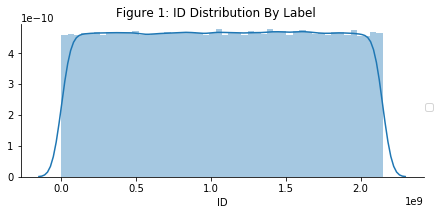

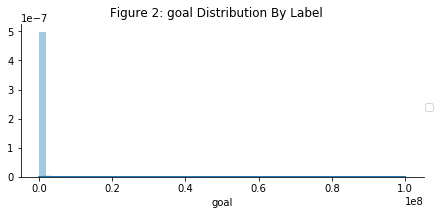

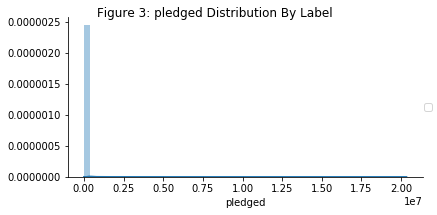

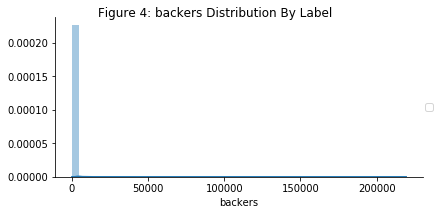

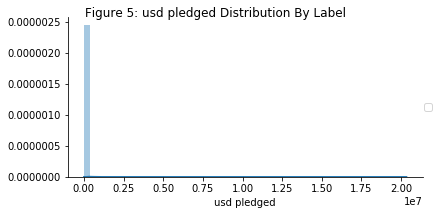

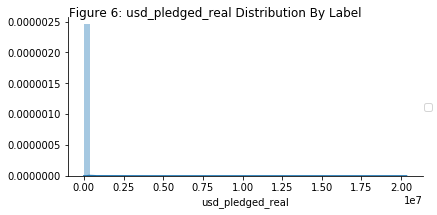

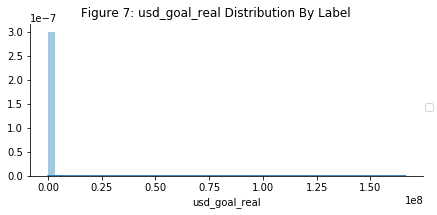

In [9]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(df.select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(df,aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution By Label"]))))
    plt.show()

In [ ]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(df.select_dtypes(include='O').columns.values)
for i in colnames[0:]:
    ax = plt.axes()
    sns.countplot(x=i, data=df, ax = ax)
    ax.set_title(''.join(map(str, list(["Figure ",colnames.index(i)+48,": ",i," Distribution By Label"]))))
    plt.show()